# Članak: Metabolism-associated molecular classiﬁcation of hepatocellular carcinoma

<hr />

Karcinom jetre jedan je od najkompliciranijih karcinoma zbog velike raznolikosti gena koji su ekspresirani u uzorcima karcinoma. To znatno otežava i analizu podataka i liječenje pacijenata. Cilj članka je podijeliti uzorke karcinoma jetre u tri grupe (klastera), od kojih svaka grupa ima određene karakteristike, npr. dobra prognoza ili loša prognoza, te na temelju 90 metaboličkih gena predvidjeti kojoj grupi karcinom pripada.

<hr />

In [1]:
from gtfparse import read_gtf
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from lifelines import CoxPHFitter
from lifelines.utils.printer import Printer

%matplotlib inline

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


## Gene transfer format (GTF)

Ovakva vrsta dokumenta sadrži informacije o strukturi gena

In [2]:
gtf = read_gtf('gencode.v22.annotation.gtf')

/Users/benjamin/opt/anaconda3/lib/python3.8/site-packages/gtfparse/read_gtf.py:151: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  result = parse_gtf(
/Users/benjamin/opt/anaconda3/lib/python3.8/site-packages/gtfparse/read_gtf.py:151: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  result = parse_gtf(
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_status', 'gene_name', 'level', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_status', 'transcript_name', 'tag', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid']


In [3]:
gtf['length'] = gtf['end'].sub(gtf['start'], axis = 0)
gtf3 = gtf.loc[gtf['feature'].str.match('gene')]
gtf4 = gtf3[["gene_name","gene_id","length"]].reset_index().drop(columns=["index"])
GTF = gtf4.drop_duplicates('gene_name', keep='first').sort_values(by=['gene_name']).reset_index().drop(columns=["index"])

GTF.to_pickle("annotation.pkl")

GTF

,gene_name,gene_id,length
0,5S_rRNA,ENSG00000252830.2,109
1,5_8S_rRNA,ENSG00000275877.1,151
2,7SK,ENSG00000277313.1,249
3,A1BG,ENSG00000121410.10,8321
4,A1BG-AS1,ENSG00000268895.4,7432
...,...,...,...
58382,snoZ40,ENSG00000201410.1,71
58383,snoZ6,ENSG00000253067.1,67
58384,snosnR66,ENSG00000212397.1,98
58385,uc_338,ENSG00000277916.1,168


In [4]:
# alternativno, za brže učitavanje

GTF = pd.read_pickle("annotation.pkl")

## Popis 2752 metaboličkih gena

In [5]:
mbg = pd.ExcelFile('41586_2011_BFnature10350_MOESM321_ESM.xls').parse('All metabolic genes')
mbg = mbg.rename(columns={'Gene Symbol': 'gene_name'})
mbg

,Gene Name,gene_name,Entrez Gene ID,Classification
0,"ATP-binding cassette, sub-family A (ABC1), mem...",ABCA1,19,ABC Transporter
1,"ATP-binding cassette, sub-family A (ABC1), mem...",ABCA10,10349,ABC Transporter
2,"ATP-binding cassette, sub-family A (ABC1), mem...",ABCA12,26154,ABC Transporter
3,"ATP-binding cassette, sub-family A (ABC1), mem...",ABCA13,154664,ABC Transporter
4,"ATP-binding cassette, sub-family A (ABC1), mem...",ABCA2,20,ABC Transporter
...,...,...,...,...
2747,"pyridoxal (pyridoxine, vitamin B6) phosphatase",PDXP,57026,Vitamin B6
2748,phosphatase orphan 2,PHOSPHO2,493911,Vitamin B6
2749,pyridoxamine 5'-phosphate oxidase,PNPO,55163,Vitamin B6
2750,dicarbonyl/L-xylulose reductase,DCXR,51181,Xyulose


## 111 gena koji se razlikuju u GTF dokumentu

In [6]:
mg = ["NCEH1","EPHX4","EPHX3","AOC1","ASIC2","ASIC1","ASIC3","ASIC4","ASIC5","CCDC102B",
       "AZIN2","ETNPPL","PHYKPL","AK4","AKR1E2","KDM1B","KDM1A","ASAH2B","NAAA","ATP5C1P1","MT-ATP6",
       "MT-ATP8","B4GAT1","BCO1","SLC25A47","SLC17A9","SLC18B1","IDNK","NMRK1","AK8",
       "ADCK3","CES5A","CHKB","CKB","CKMT1B","CLCA3P","CMPK1","MT-CO1","MT-CO2","MT-CO3",
       "CTPS1","CYB561A3","ECI1","AWAT1","AWAT2","DGAT2L7P","DLST","EXT2","ENGASE",
       "CHST15","GALNT16","GALNT15","GALNT18","MOGS","COLGALT1","COLGALT2","GXYLT1",
       "GXYLT2","TECR","PPIP5K2","PPIP5K1","ISCA1P1","KCNE5","CERS1","CERS2",
       "CERS3","CERS4","CERS5","CERS6","ZACN","SLCO1B7","LCLAT1","NAA35","SLC25A51",
       "SLC25A52","SLC25A53","MFSD2A","MARC1","MARC2","NAPEPLD","NAPRT","NAA40",
       "NAA30","NAA50","NAA60","NAA20","NDUFA4P2","PNP","NT5C3A","NT5C3B","SLC51A","SLC51B",
       "LPPR5", "ECI2","HPGDS","PIKFYVE","PKM","PSAT1","MSMO1","SC5D","SDR16C6P",
       "MSRB1","SLC8B1","SLC9C1","SLC9C2","TECRL","ACOT13","UQCR10","UGGT1","UGGT2","UQCR11"]

final_list = set()

final_list.update(set.intersection(set(mbg["gene_name"].tolist()),set(GTF["gene_name"].tolist())))
final_list.update(set(mg))
                  
print(len(final_list))

2743


In [7]:
df = pd.DataFrame(sorted(final_list))
df = df.rename(columns={0: 'gene_name'})
df

gtf = pd.merge(df,GTF,on="gene_name")
gtf

,gene_name,gene_id,length
0,A1CF,ENSG00000148584.13,86266
1,A4GALT,ENSG00000128274.14,29177
2,A4GNT,ENSG00000118017.3,8669
3,AACS,ENSG00000081760.15,77954
4,AADAC,ENSG00000114771.12,14451
...,...,...,...
2738,XYLB,ENSG00000093217.8,74588
2739,XYLT1,ENSG00000103489.10,369112
2740,XYLT2,ENSG00000015532.8,17046
2741,ZACN,ENSG00000186919.11,11705


# ICGC

In [8]:
filename = 'exp_seq.tsv'

patients=[]
chunksize = 500000

for index,chunk in tqdm(enumerate(pd.read_csv(filename, chunksize=chunksize,sep='\t'))):#,header=0):

    partition = chunk[["icgc_donor_id","gene_id","raw_read_count","normalized_read_count","submitted_sample_id","analysis_id"]]#.rename(columns={'gene_id': 'gene_name'})
    c = np.array(list(Counter(list(partition.icgc_donor_id)).items()))
    
    point=0
    for num,i in enumerate(c[:,1]):
        if num == 0 and index != 0:
            cache = partition[point:point+int(i)].to_numpy()
            spojeno = np.concatenate((savepoint,cache))
            patients.append(spojeno)
            
        elif num == len(c[:,1])-1 and index!= 16:
            savepoint = partition[point:point+int(i)].to_numpy()
        else:
            patients.append(partition[point:point+int(i)].to_numpy())
        
        point+=int(i)

17it [00:33,  1.99s/it]


In [9]:
icgc_data=[]

icgc_donor_list=[]
for index, sample in tqdm(enumerate(patients)):
    
    patient_sample = pd.DataFrame(sample,columns = ("icgc_donor_id","gene_id","raw_read_count","normalized_read_count","submitted_sample_id","analysis_id")).rename(columns={'gene_id': 'gene_name'})
    patient= patient_sample[patient_sample['analysis_id'].str.contains('Cancer-')]
    p = pd.merge(patient,gtf,on="gene_name").sort_values(by=['gene_name']).reset_index().drop(columns=["index"])

    
    icgc_donor_list.append(p["icgc_donor_id"].drop_duplicates().tolist()[0])
    
    df = p[["gene_name","raw_read_count","length"]]

    gene_list = df["gene_name"].values
    mpatient = pd.DataFrame(df[["raw_read_count"]].values)
    pt = mpatient.T.set_axis(gene_list, axis=1, inplace=False)
    newp = pt.loc[:,~pt.columns.duplicated()]
    icgc_data.append(newp)

232it [00:17, 13.42it/s]


In [10]:
temp = pd.DataFrame()
for i in tqdm(icgc_data):
    
    temp = pd.concat([temp,i], axis=0)

TEMP = temp.fillna(0).reset_index().drop(columns=["index"])
ICGC_data = TEMP.reindex(sorted(TEMP.columns), axis=1)
ICGC_data

100%|██████████| 232/232 [00:52<00:00,  4.46it/s]


,A1CF,A4GALT,A4GNT,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AANAT,...,VKORC1,VKORC1L1,WBSCR17,WWOX,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
0,517706,24433,14343,65164,940036,0,0,0,7520,823,...,288866,44001,3971,12047,133905,126054,11379,161897,115787,119047
1,2817787,16086,0,55440,2967140,178,0,0,44394,202,...,356834,116324,497,25587,577807,453011,22749,125651,61974,213398
2,2905919,5617,0,53638,1995971,202,0,0,29962,404,...,556626,53693,404,80250,513811,266670,2559,126537,85973,135333
3,2555805,22087,0,21662,2370380,0,0,202,20528,80,...,512860,84092,4422,94068,418527,310550,18589,155009,65675,263805
4,2271215,12322,0,125329,42652,132,0,71,11918,762,...,374068,88454,0,64834,222555,132481,15760,236199,238751,283855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,815,34566,1371,29166,5827,0,202,202,4837,2885,...,149452,34755,1616,16324,202,4591,37048,62772,82576,133172
228,458500,13172,808,43388,622658,0,0,0,34899,97,...,272874,27870,0,55510,28959,202766,2236,104405,66486,143683
229,6040232,22578,404,199495,12116508,524,0,0,97152,612,...,938094,95701,1010,107334,105798,439372,11106,320020,225859,311935
230,803533,6789,404,58363,967602,0,0,0,94638,91,...,150257,83005,202,34729,148447,175787,3982,128161,97215,95199


In [11]:
df = ICGC_data

s = pd.Series(icgc_donor_list)

df = df.set_index([s])
df  = df.rename_axis('gene_id', axis=1)
df  = df.rename_axis('donor_id', axis=0)

ICGC_data = df

In [12]:
ICGC_data

gene_id,A1CF,A4GALT,A4GNT,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AANAT,...,VKORC1,VKORC1L1,WBSCR17,WWOX,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
donor_id,,,,,,,,,,,,,,,,,,,,,
DO50855,517706,24433,14343,65164,940036,0,0,0,7520,823,...,288866,44001,3971,12047,133905,126054,11379,161897,115787,119047
DO50857,2817787,16086,0,55440,2967140,178,0,0,44394,202,...,356834,116324,497,25587,577807,453011,22749,125651,61974,213398
DO50859,2905919,5617,0,53638,1995971,202,0,0,29962,404,...,556626,53693,404,80250,513811,266670,2559,126537,85973,135333
DO50850,2555805,22087,0,21662,2370380,0,0,202,20528,80,...,512860,84092,4422,94068,418527,310550,18589,155009,65675,263805
DO50844,2271215,12322,0,125329,42652,132,0,71,11918,762,...,374068,88454,0,64834,222555,132481,15760,236199,238751,283855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO23523,815,34566,1371,29166,5827,0,202,202,4837,2885,...,149452,34755,1616,16324,202,4591,37048,62772,82576,133172
DO23521,458500,13172,808,43388,622658,0,0,0,34899,97,...,272874,27870,0,55510,28959,202766,2236,104405,66486,143683
DO23529,6040232,22578,404,199495,12116508,524,0,0,97152,612,...,938094,95701,1010,107334,105798,439372,11106,320020,225859,311935


# TCGA

In [13]:
df = pd.read_json('metadata.cart.2021-12-03.json')
DF = df[df['data_category'].str.contains('Transcriptome Profiling')].reset_index().drop(columns=["index"])

d = dict()
for i in range(len(DF["associated_entities"].values)):
    temp = []
    for key,item in DF.iloc[i,[2]]["associated_entities"][0].items():
        
        if key == "entity_submitter_id":
            temp.append(str(item)[:-16])
            
    file = DF.iloc[i,[3]]["file_name"]
    
    if str(file)[-16:]==".htseq.counts.gz":
        temp.append(DF.iloc[i,[3]]["file_name"])
    ##########################################################################
    #Zbog nekog razloga fali ime file-a za taj key.
    else:
        temp.append("9700948e-21f5-42ae-9cb5-f18c745887ce.htseq.counts.gz")
    ##########################################################################
    
    d[temp[0]]=temp[1]

files = pd.DataFrame(d.items(), columns=['case_submitter_id', 'file_name'])
files

col_one_list = files['file_name'].tolist()
col_one_list

s = set()
for dirs in col_one_list:
    #print(dirs)
    s.add(dirs)

print(len(s))

371


In [14]:
import os
import pandas as pd
rootdir = 'TCGA/'

data=[]
patient_id=[]
for index,(subdir, dirs, files) in tqdm(enumerate(os.walk(rootdir))):
    for file in files:
        #print(file)
        if file in s:#file.endswith('gz'):
            patient_id.append(str(file)[:-16])
            df = pd.read_csv(subdir+"/"+file, compression='gzip',names=["gene_id","raw_read_count"],sep="\t")
            df.drop(df.tail(5).index,inplace=True)
            data.append(df)

425it [00:20, 20.31it/s]


In [15]:
len(patient_id)

371

In [16]:
tcga_data=[]
for p in tqdm(data):
    
    p = pd.merge(p,gtf,on="gene_id").sort_values(by=['gene_name']).reset_index().drop(columns=["index"])
   
    df = p[["gene_name","raw_read_count","length"]]

    gene_list = df["gene_name"].values
    mpatient = pd.DataFrame(df[["raw_read_count"]].values)
    pt = mpatient.T.set_axis(gene_list, axis=1, inplace=False)
    newp = pt.loc[:,~pt.columns.duplicated()]
    
    tcga_data.append(newp)

100%|██████████| 371/371 [00:07<00:00, 47.38it/s]


In [17]:
TCGA_data = pd.concat(tcga_data).reset_index().drop(columns=["index"])
TCGA_data = TCGA_data.reindex(sorted(TCGA_data.columns), axis=1)
TCGA_data

,A1CF,A4GALT,A4GNT,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AANAT,...,VKORC1,VKORC1L1,WBSCR17,WWOX,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
0,10382,124,3,307,15745,0,0,0,1274,0,...,3016,1537,31,337,3537,846,34,636,33,1512
1,14443,110,5,233,20755,0,0,0,2045,1,...,6819,2359,14,505,7419,2566,101,658,6,1951
2,8530,126,0,236,22903,0,0,0,593,2,...,2034,1498,1,532,5637,2251,6,3407,23,595
3,3327,108,0,411,3837,1,0,0,580,2,...,4957,1321,2,911,4459,386,36,712,14,427
4,6278,251,10,630,9055,0,0,0,164,8,...,1287,1870,268,358,3958,2702,215,1182,19,1212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,7262,185,1,881,16312,0,0,0,352,2,...,6937,1977,27,725,1078,3250,52,739,7,1036
367,17236,180,0,425,58952,1,0,0,404,5,...,2505,2497,4,339,1684,2163,56,1809,18,651
368,8077,238,10,2733,14040,0,0,0,275,5,...,2569,3531,66,1647,3846,1040,194,2252,14,1285
369,10468,15,2,144,13836,0,0,0,2404,0,...,7454,1436,1,458,3661,1620,17,617,8,1346


In [18]:
df = TCGA_data

s = pd.Series(patient_id)

df = df.set_index([s])
df  = df.rename_axis('gene_id', axis=1)
df  = df.rename_axis('donor_id', axis=0)

TCGA_data = df

In [19]:
TCGA_data

gene_id,A1CF,A4GALT,A4GNT,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AANAT,...,VKORC1,VKORC1L1,WBSCR17,WWOX,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
donor_id,,,,,,,,,,,,,,,,,,,,,
38ed53de-d5bc-4c94-8f5d-c2b8e8e65782,10382,124,3,307,15745,0,0,0,1274,0,...,3016,1537,31,337,3537,846,34,636,33,1512
6e146a57-21b2-4587-b888-01ed03ea9498,14443,110,5,233,20755,0,0,0,2045,1,...,6819,2359,14,505,7419,2566,101,658,6,1951
99e82612-a602-459b-8a60-80a812bf9d88,8530,126,0,236,22903,0,0,0,593,2,...,2034,1498,1,532,5637,2251,6,3407,23,595
9dd14a4d-a863-4994-b5c6-b5bec92ff818,3327,108,0,411,3837,1,0,0,580,2,...,4957,1321,2,911,4459,386,36,712,14,427
7ab845f8-320e-4c93-9d5c-bf66bb8d121c,6278,251,10,630,9055,0,0,0,164,8,...,1287,1870,268,358,3958,2702,215,1182,19,1212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87d34b64-cd78-46db-a463-ce802f866b59,7262,185,1,881,16312,0,0,0,352,2,...,6937,1977,27,725,1078,3250,52,739,7,1036
10d6deec-fd89-4115-92f5-c9def40428b5,17236,180,0,425,58952,1,0,0,404,5,...,2505,2497,4,339,1684,2163,56,1809,18,651
3f87f996-3fc0-48eb-89c5-7bfdc5e72dce,8077,238,10,2733,14040,0,0,0,275,5,...,2569,3531,66,1647,3846,1040,194,2252,14,1285


# Normalizacija i spajanje

In [20]:
genes = sorted(list(set.intersection(set(TCGA_data.columns),set(ICGC_data.columns))))
len(genes)

2673

In [21]:
tcga = TCGA_data[genes]
icgc = ICGC_data[genes]

In [22]:
gl_length=[]
for i in tqdm(genes):
    #print(i,gene_dict_len[i])
    
    l = gtf[gtf['gene_name'].str.contains(str(i))]["length"].tolist()[0]
    
    if l is not None:
        gl_length.append(l)

100%|██████████| 2673/2673 [00:03<00:00, 764.44it/s]


In [23]:
arrs=[]
for index, row in tcga.iterrows():
    
    a = []
    for i,j in zip(row.to_numpy(),gl_length):
        #print(i,j,i/j)
        a.append(i/(j/1000))
        
    scaling_factor=(np.sum(a)/1000000)
    
    b=[]
    for i in a:
        b.append(i/scaling_factor)
        
    arrs.append(b)
    
array=[]
for p in tqdm(arrs):
    
    mpatient = pd.DataFrame(p)
    pt = mpatient.T.set_axis(tcga.columns, axis=1, inplace=False)
    newp = pt.loc[:,~pt.columns.duplicated()]
    
    array.append(newp)

a = pd.concat(array).reset_index().drop(columns=["index"])
tcga_norm = a.reindex(sorted(tcga.columns), axis=1)
tcga_norm

100%|██████████| 371/371 [00:00<00:00, 825.79it/s]


gene_id,A1CF,A4GALT,A4GNT,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AANAT,...,VKORC1,VKORC1L1,WBSCR17,WWOX,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
0,198.228965,7.000141,0.570004,6.486728,1794.611776,0.000000,0.0,0.0,66.665608,0.000000,...,966.858649,29.336544,0.087819,0.498610,72.466481,18.682163,0.888443,9.517735,4.643744,174.891036
1,224.175181,5.048029,0.772273,4.002094,1923.067882,0.000000,0.0,0.0,86.990085,0.079862,...,1777.036583,36.602188,0.032240,0.607389,123.563873,46.063557,2.145440,8.004725,0.686356,183.449722
2,145.414302,6.350789,0.000000,4.452166,2330.731396,0.000000,0.0,0.0,27.705061,0.175428,...,582.176409,25.528124,0.002529,0.702773,103.115073,44.381736,0.139983,45.521928,2.889709,61.447573
3,94.625461,9.081927,0.000000,12.935949,651.461521,0.089471,0.0,0.0,45.209482,0.292682,...,2367.116810,37.558395,0.008440,2.007793,136.084514,12.697354,1.401272,15.871780,2.934617,73.572033
4,164.311071,19.423087,2.604451,18.246826,1414.737060,0.000000,0.0,0.0,11.763477,1.077322,...,565.548199,48.925595,1.040691,0.726062,111.157131,81.790254,7.701029,24.246743,3.664944,192.166556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,119.989309,9.037682,0.164421,16.108810,1608.923073,0.000000,0.0,0.0,15.939522,0.170030,...,1924.436399,32.654420,0.066190,0.928260,19.112658,62.106974,1.175857,9.570203,0.852418,103.699278
367,242.971328,7.502225,0.000000,6.629927,4960.881412,0.044345,0.0,0.0,15.607963,0.362659,...,592.886871,35.187311,0.008366,0.370308,25.472798,35.265152,1.080367,19.986996,1.870076,55.594164
368,200.508562,17.468629,2.470322,75.079907,2080.614914,0.000000,0.0,0.0,18.709486,0.638650,...,1070.760902,87.625307,0.243091,3.168267,102.449099,29.859799,6.590970,43.816900,2.561410,193.248281
369,223.881443,0.948516,0.425652,3.408146,1766.471749,0.000000,0.0,0.0,140.907845,0.000000,...,2676.636109,30.701374,0.003173,0.759041,84.017574,40.071915,0.497586,10.342606,1.260993,174.393026


In [24]:
arrs=[]
for index, row in icgc.iterrows():
    
    a = []
    for i,j in zip(row.to_numpy(),gl_length):
        #print(i,j,i/j)
        a.append(i/(j/1000))
        
    scaling_factor=(np.sum(a)/1000000)
    
    b=[]
    for i in a:
        b.append(i/scaling_factor)
        
    arrs.append(b)
    
array=[]
for p in tqdm(arrs):
    
    mpatient = pd.DataFrame(p)
    pt = mpatient.T.set_axis(icgc.columns, axis=1, inplace=False)
    newp = pt.loc[:,~pt.columns.duplicated()]
    
    array.append(newp)

a = pd.concat(array).reset_index().drop(columns=["index"])
icgc_norm = a.reindex(sorted(icgc.columns), axis=1)
icgc_norm

100%|██████████| 232/232 [00:00<00:00, 772.74it/s]


gene_id,A1CF,A4GALT,A4GNT,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AANAT,...,VKORC1,VKORC1L1,WBSCR17,WWOX,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
0,189.962493,26.506994,52.371537,26.460232,2059.069034,0.000000,0.000000,0.000000,7.562212,1.553798,...,1779.617428,16.139728,0.216185,0.342538,52.722680,53.494852,5.714175,46.560098,313.121368,264.626169
1,269.609379,4.550655,0.000000,5.870179,1694.753863,0.053576,0.000000,0.000000,11.641192,0.099446,...,573.242820,11.126156,0.007055,0.189711,59.323348,50.130990,2.978886,9.422870,43.702331,123.693492
2,442.092249,2.526579,0.000000,9.030322,1812.697697,0.096673,0.000000,0.000000,12.492418,0.316243,...,1421.799789,8.165750,0.009119,0.946063,83.878145,46.921756,0.532800,15.088197,96.396157,124.727661
3,395.262010,10.099343,0.000000,3.707295,2188.351560,0.000000,0.000000,0.119568,8.700622,0.063659,...,1331.685736,13.000529,0.101465,1.127313,69.453936,55.546870,3.934397,18.789045,74.855839,247.155371
4,398.254103,6.388255,0.000000,24.319511,44.646063,0.072812,0.000000,0.047650,5.727324,0.687491,...,1101.280957,15.504883,0.000000,0.880948,41.875055,26.867441,3.782013,32.461642,308.542826,301.528406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,0.295213,37.019155,4.941815,11.691130,12.599843,0.000000,0.499212,0.280049,4.801763,5.376930,...,908.919953,12.584751,0.086848,0.458195,0.078514,1.923341,18.365718,17.821109,220.445090,292.227403
228,204.862033,17.400947,3.592561,21.453247,1660.785219,0.000000,0.000000,0.000000,42.734778,0.223000,...,2047.056628,12.448244,0.000000,1.921935,13.884228,104.782311,1.367284,36.562330,218.937718,388.917242
229,405.504087,4.481528,0.269894,14.820911,4855.800656,0.110662,0.000000,0.000000,17.874738,0.211399,...,1057.385950,6.422544,0.010060,0.558373,7.621406,34.114946,1.020385,16.838723,111.749930,126.863122
230,146.223049,3.652725,0.731584,11.753061,1051.115971,0.000000,0.000000,0.000000,47.198044,0.085205,...,459.084249,15.099597,0.005454,0.489722,28.986753,36.997261,0.991695,18.279252,130.380800,104.948002


In [25]:
#https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

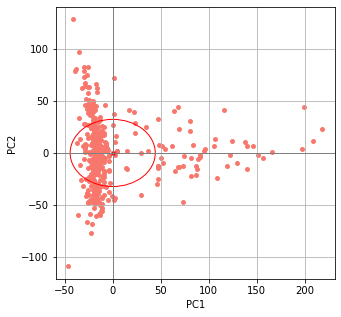

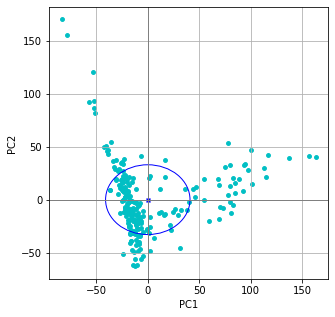

In [26]:
fig, ax = plt.subplots(figsize=(5,5))

pca = sklearnPCA(n_components=2)

Y = pca.fit_transform(tcga_norm.to_numpy()/1000)

x1 = Y[:,0]
y1 = Y[:,1]

mu_x1 = np.mean(x1)
mu_y1 = np.mean(y1)
    
ax.scatter(x1, y1, s=15,color = "#F8776D")
confidence_ellipse(x1, y1, ax,n_std=1, edgecolor='red')
ax.scatter(mu_x1, mu_y1, c='red', s=15,marker="x")

ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(5,5))

pca = sklearnPCA(n_components=2)

Y = pca.fit_transform(icgc_norm.to_numpy()/1000)

x1 = Y[:,0]
y1 = Y[:,1]

mu_x1 = np.mean(x1)
mu_y1 = np.mean(y1)
    
ax.scatter(x1, y1, s=15,color = "#01BFC4")
confidence_ellipse(x1, y1, ax,n_std=1, edgecolor='blue')
ax.scatter(mu_x1, mu_y1, c='blue', s=15,marker="x")

ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

In [27]:
X1 = pd.DataFrame(MinMaxScaler().fit_transform(tcga_norm)).set_axis(tcga_norm.columns, axis=1, inplace=False)
X2 = pd.DataFrame(MinMaxScaler().fit_transform(icgc_norm)).set_axis(icgc_norm.columns, axis=1, inplace=False)

#dataset1 = pd.concat([X1,X2], axis=0).fillna(0)
dataset = pd.concat([tcga_norm,icgc_norm], axis=0).fillna(0)

dataset

gene_id,A1CF,A4GALT,A4GNT,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AANAT,...,VKORC1,VKORC1L1,WBSCR17,WWOX,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
0,198.228965,7.000141,0.570004,6.486728,1794.611776,0.000000,0.000000,0.000000,66.665608,0.000000,...,966.858649,29.336544,0.087819,0.498610,72.466481,18.682163,0.888443,9.517735,4.643744,174.891036
1,224.175181,5.048029,0.772273,4.002094,1923.067882,0.000000,0.000000,0.000000,86.990085,0.079862,...,1777.036583,36.602188,0.032240,0.607389,123.563873,46.063557,2.145440,8.004725,0.686356,183.449722
2,145.414302,6.350789,0.000000,4.452166,2330.731396,0.000000,0.000000,0.000000,27.705061,0.175428,...,582.176409,25.528124,0.002529,0.702773,103.115073,44.381736,0.139983,45.521928,2.889709,61.447573
3,94.625461,9.081927,0.000000,12.935949,651.461521,0.089471,0.000000,0.000000,45.209482,0.292682,...,2367.116810,37.558395,0.008440,2.007793,136.084514,12.697354,1.401272,15.871780,2.934617,73.572033
4,164.311071,19.423087,2.604451,18.246826,1414.737060,0.000000,0.000000,0.000000,11.763477,1.077322,...,565.548199,48.925595,1.040691,0.726062,111.157131,81.790254,7.701029,24.246743,3.664944,192.166556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,0.295213,37.019155,4.941815,11.691130,12.599843,0.000000,0.499212,0.280049,4.801763,5.376930,...,908.919953,12.584751,0.086848,0.458195,0.078514,1.923341,18.365718,17.821109,220.445090,292.227403
228,204.862033,17.400947,3.592561,21.453247,1660.785219,0.000000,0.000000,0.000000,42.734778,0.223000,...,2047.056628,12.448244,0.000000,1.921935,13.884228,104.782311,1.367284,36.562330,218.937718,388.917242
229,405.504087,4.481528,0.269894,14.820911,4855.800656,0.110662,0.000000,0.000000,17.874738,0.211399,...,1057.385950,6.422544,0.010060,0.558373,7.621406,34.114946,1.020385,16.838723,111.749930,126.863122
230,146.223049,3.652725,0.731584,11.753061,1051.115971,0.000000,0.000000,0.000000,47.198044,0.085205,...,459.084249,15.099597,0.005454,0.489722,28.986753,36.997261,0.991695,18.279252,130.380800,104.948002


In [28]:
df = dataset

s = pd.Series(patient_id+icgc_donor_list)

df = df.set_index([s])
df  = df.rename_axis('gene_id', axis=1)
df  = df.rename_axis('donor_id', axis=0)

dataset = df
dataset.T

donor_id,38ed53de-d5bc-4c94-8f5d-c2b8e8e65782,6e146a57-21b2-4587-b888-01ed03ea9498,99e82612-a602-459b-8a60-80a812bf9d88,9dd14a4d-a863-4994-b5c6-b5bec92ff818,7ab845f8-320e-4c93-9d5c-bf66bb8d121c,edf02d6d-619f-4325-a585-dca7bf5afbeb,ffeed225-c2a3-4b4c-954c-4816903782a9,6c86f9ae-9e88-4eae-9ba3-4866943cca7f,75e0a216-2200-4c63-81a5-1e8d6ef4d559,e18e0c27-029a-48dc-bdf4-ec00a0702db0,...,DO23528,DO23527,DO23526,DO23525,DO23524,DO23523,DO23521,DO23529,DO23509,DO23508
gene_id,,,,,,,,,,,,,,,,,,,,,
A1CF,198.228965,224.175181,145.414302,94.625461,164.311071,291.690921,184.995960,487.651516,175.869239,152.423944,...,316.641552,306.219539,231.188674,181.651015,120.329499,0.295213,204.862033,405.504087,146.223049,106.863570
A4GALT,7.000141,5.048029,6.350789,9.081927,19.423087,11.025335,53.647353,6.319019,12.448287,3.324660,...,6.824529,7.335714,20.124339,7.776483,16.877361,37.019155,17.400947,4.481528,3.652725,8.196839
A4GNT,0.570004,0.772273,0.000000,0.000000,2.604451,1.236922,34.127697,0.000000,0.171007,0.385852,...,1.826339,0.530767,20.672819,0.000000,4.379342,4.941815,3.592561,0.269894,0.731584,0.000000
AACS,6.486728,4.002094,4.452166,12.935949,18.246826,6.740139,34.024638,21.336338,9.109221,46.063131,...,6.690886,5.217829,50.348873,15.469748,19.981986,11.691130,21.453247,14.820911,11.753061,22.718691
AADAC,1794.611776,1923.067882,2330.731396,651.461521,1414.737060,7016.008587,1257.889355,1118.657524,2278.630454,568.602388,...,973.292133,2441.228965,750.045148,1096.221561,2031.014415,12.599843,1660.785219,4855.800656,1051.115971,985.994433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYLB,18.682163,46.063557,44.381736,12.697354,81.790254,52.281219,48.612637,156.620341,38.776842,43.903945,...,109.948836,35.780824,27.626109,31.877947,33.429310,1.923341,104.782311,34.114946,36.997261,12.953450
XYLT1,0.888443,2.145440,0.139983,1.401272,7.701029,2.891913,26.851452,3.422790,1.364072,0.397994,...,1.376923,4.914607,5.004022,0.544402,4.418321,18.365718,1.367284,1.020385,0.991695,0.402343
XYLT2,9.517735,8.004725,45.521928,15.871780,24.246743,34.292930,59.260680,22.204001,34.036127,15.787964,...,26.252725,15.241920,40.844723,26.105606,25.195574,17.821109,36.562330,16.838723,18.279252,19.500970


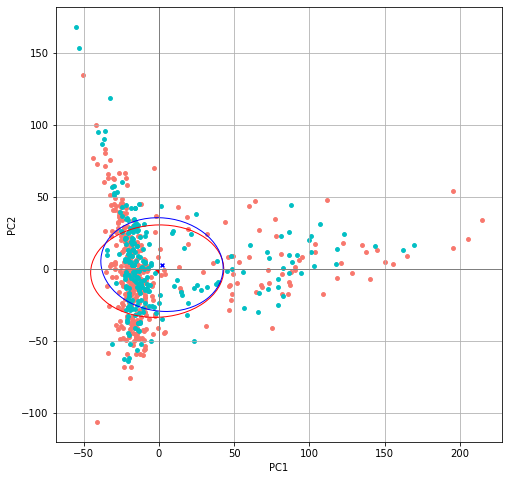

In [29]:
fig, ax = plt.subplots(figsize=(8,8))

pca = sklearnPCA(n_components=2)

Y = pca.fit_transform(dataset.to_numpy()/1000)

#####################################################################

x1 = Y[:371,0]
y1 = Y[:371,1]

mu_x1 = np.mean(x1)
mu_y1 = np.mean(y1)
    
ax.scatter(x1, y1, s=15,color = "#F8776D")
confidence_ellipse(x1, y1, ax,n_std=1, edgecolor='red')
ax.scatter(mu_x1, mu_y1, c='red', s=15,marker="x")

#####################################################################

x2 = Y[371:,0]
y2 = Y[371:,1]

mu_x2 = np.mean(x2)
mu_y2 = np.mean(y2)

ax.scatter(x2, y2, s=15,color = "#01BFC4")
confidence_ellipse(x2, y2, ax,n_std=1, edgecolor='blue')
ax.scatter(mu_x2, mu_y2, c='blue', s=15,marker="x")

#####################################################################

ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

## Batch Effect Correction

In [30]:
from combat.pycombat import pycombat

print(np.shape(dataset),np.shape(tcga_norm.astype(float)),np.shape(icgc_norm.astype(float)))

df = dataset.astype(float).T

dataset1 = tcga_norm.astype(float).T
dataset2 = icgc_norm.astype(float).T

print(np.shape(dataset1),np.shape(dataset2))

df_expression = pd.concat([dataset1,dataset2],join="inner",axis=1)

batch = []
datasets = [dataset1,dataset2]

for j in range(len(datasets)):
    batch.extend([j for _ in range(len(datasets[j].columns))])
    
print(np.shape(batch))

df_corrected = pycombat(df_expression,batch)

print("end")

(603, 2673) (371, 2673) (232, 2673)
(2673, 371) (2673, 232)
(603,)
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
end


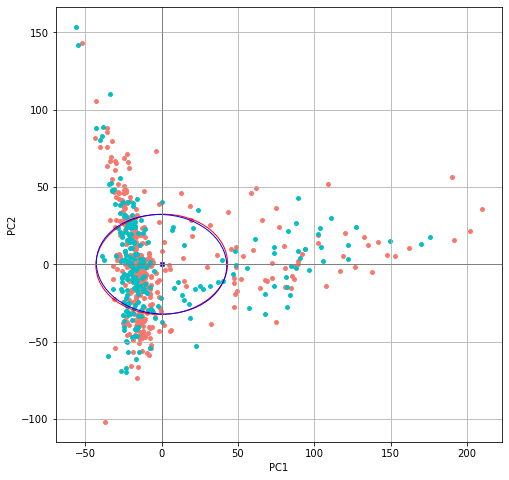

In [31]:
fig, ax = plt.subplots(figsize=(8,8))

pca = sklearnPCA(n_components=2)

Y = pca.fit_transform(df_corrected.T.to_numpy()/1000)

x1 = Y[:371,0]
y1 = Y[:371,1]

mu_x1 = np.mean(x1)
mu_y1 = np.mean(y1)
    
ax.scatter(x1, y1, s=15,color = "#F8776D")
confidence_ellipse(x1, y1, ax,n_std=1, edgecolor='red')
ax.scatter(mu_x1, mu_y1, c='red', s=15,marker="x")

x2 = Y[371:,0]
y2 = Y[371:,1]

mu_x2 = np.mean(x2)
mu_y2 = np.mean(y2)

ax.scatter(x2, y2, s=15,color = "#01BFC4")
confidence_ellipse(x2, y2, ax,n_std=1, edgecolor='blue')
ax.scatter(mu_x2, mu_y2, c='blue', s=15,marker="x")

ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)

plt.xlabel("PC1")
plt.ylabel("PC2")
#import matplotlib.ticker as mticker
#ax.xaxis.set_major_locator(mticker.MultipleLocator(50))
#ax.yaxis.set_major_locator(mticker.MultipleLocator(50))
plt.grid()
plt.show()

# Median absolute deviation

In [32]:
from scipy import stats

df = df_corrected
MAD = []
indexs=[]
for num,(index, row) in enumerate(df.iterrows()):
    mad = stats.median_abs_deviation(row)
    MAD.append(mad)
    if mad < 0.5:
        #print(num,mad) 
        indexs.append(num)
        
print(len(indexs))

newdf  = df.T.drop(df.T.columns[indexs], axis = 1)
DF = newdf.reindex(sorted(newdf.columns), axis=1)
DF

492


gene_id,A1CF,A4GALT,A4GNT,AACS,AADAC,AADAT,AASDH,AASDHPPT,AASS,ABAT,...,VDAC2,VDAC3,VKORC1,VKORC1L1,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
0,224.518251,6.080021,-0.392517,5.628013,1815.001237,65.985677,10.254550,98.590195,97.935638,252.230544,...,152.734992,359.439574,1047.477543,19.948712,79.491941,18.642186,1.159269,9.603232,85.939119,194.782534
1,255.495907,4.371351,-0.130795,3.016931,1935.799718,84.922695,12.572281,91.958489,158.316034,414.247103,...,136.198872,283.770050,1932.263096,25.773488,143.789933,46.171826,2.846241,8.170569,63.301343,204.297533
2,161.461870,5.511647,-1.130063,3.489908,2319.161275,29.684790,15.457675,135.930744,273.625569,112.276948,...,156.636504,416.183180,627.370707,16.895550,118.058349,44.480900,0.154784,43.695447,75.905369,68.663355
3,100.824154,7.902192,-1.130063,12.405444,739.997350,45.994264,12.289441,123.084189,29.958576,133.805022,...,94.833096,384.095402,2576.682597,26.540067,159.545180,12.624975,1.847519,15.619849,76.162260,82.142553
4,184.023064,16.953734,2.239916,17.986600,1457.771910,14.831465,23.118508,109.108498,89.797280,261.876093,...,218.847731,326.434425,609.211240,35.653009,128.178009,82.091953,10.302212,23.550066,80.340009,213.988351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,5.975748,50.825808,4.285170,12.523481,-240.990008,-2.483306,16.094313,147.720103,-2.620187,2.035854,...,398.263015,590.929698,807.526151,37.964067,7.916621,2.194635,13.764792,18.536899,97.960197,252.651616
228,174.365200,23.501875,3.232084,21.621618,1610.067465,41.050697,18.785534,171.686330,6.968554,135.138792,...,215.510492,769.587983,1822.297763,37.575333,18.875453,104.139793,0.760138,39.263981,97.017666,337.301206
229,339.523976,5.507910,0.638759,15.440387,5198.351456,12.519955,18.856227,139.207263,81.918175,168.744628,...,150.630730,111.869856,939.899602,20.415830,13.904091,34.100246,0.494743,17.450417,29.995134,107.879231
230,126.096442,4.353566,0.999106,12.581200,925.355154,46.172985,8.217365,57.830954,697.850186,164.114659,...,118.440826,584.448311,406.449099,45.125643,30.863681,36.956954,0.472793,19.043588,41.644671,88.693079


## Usporedba odabranih gena sa člankom

In [33]:
final_genes=pd.read_excel("mol212639-sup-0006-tables1-s11.xlsx",
                  sheet_name="Table S1")

df = final_genes

new_header = df.iloc[0]
df = df[1:]
df.columns = new_header

df

final_set = set(df["Gene Symbol"].tolist())

In [34]:
len(set.intersection(set(DF.columns),final_set))

815

# SURVIVAL ANALYSIS

In [39]:
TCGA_clinical = pd.read_csv("clinical.tsv", sep='\t')

df = pd.read_json('metadata.cart.2021-12-03.json')
metadata = df[df['data_category'].str.contains('Transcriptome Profiling')].reset_index().drop(columns=["index"])

files=[]

d = dict()
for i in range(len(metadata["associated_entities"].values)):
    temp = []
    for key,item in metadata.iloc[i,[2]]["associated_entities"][0].items():
        
        if key == "entity_submitter_id":
            temp.append(str(item)[:-16])
            
    file = metadata.iloc[i,[3]]["file_name"]
    
    if str(file)[-16:]==".htseq.counts.gz":
        temp.append(metadata.iloc[i,[3]]["file_name"])
        files.append(file)
    else:
        temp.append("9700948e-21f5-42ae-9cb5-f18c745887ce.htseq.counts.gz")
    
    d[temp[0]]=temp[1]
    

files = pd.DataFrame(d.items(), columns=['case_submitter_id', 'file_name'])

TCGA_CL = TCGA_clinical.drop_duplicates(subset=['case_id'], keep='first')[["case_submitter_id","days_to_last_follow_up","days_to_death","vital_status"]].reset_index().drop(columns=["index"])

CL = pd.merge(files,TCGA_CL,on="case_submitter_id")

df = CL

df.loc[(df.vital_status == 'Dead'),'days_to_last_follow_up']=""

df = df.replace("'--", "")
#df = df.replace("0", "")

df['donor_survival_time']=df['days_to_last_follow_up']+df['days_to_death']

d = {'Alive': 1, 'Dead': 0}
data2 =  df['vital_status'].map(d)

df["status"] = data2
A = df[["donor_survival_time","status"]]

ICGC_clinical = pd.read_csv('donor.tsv', sep='\t')#,header=0)
ICGC_clinical[["donor_vital_status","donor_survival_time"]]

data = ICGC_clinical[["donor_vital_status","donor_survival_time"]]

d = {'alive': 1, 'deceased': 0}
data2 =  data['donor_vital_status'].map(d)

data["status"] = data2
data[["donor_survival_time","status"]]

B = data[["donor_survival_time","status"]]

clinical_data = pd.concat([A,B])
clinical_data = clinical_data.reset_index().drop(columns=["index"])

clinical_data = clinical_data.drop(316) #missing time
clinical_data = clinical_data.drop(43) #missing status

clinical_data

<ipython-input-39-852bc54aab3c>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["status"] = data2


,donor_survival_time,status
0,1219,1.0
1,538,1.0
2,211,1.0
3,9,1.0
4,601,0.0
...,...,...
598,1080,1.0
599,1110,1.0
600,930,1.0
601,780,0.0


In [40]:
DF

gene_id,A1CF,A4GALT,A4GNT,AACS,AADAC,AADAT,AASDH,AASDHPPT,AASS,ABAT,...,VDAC2,VDAC3,VKORC1,VKORC1L1,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
0,224.518251,6.080021,-0.392517,5.628013,1815.001237,65.985677,10.254550,98.590195,97.935638,252.230544,...,152.734992,359.439574,1047.477543,19.948712,79.491941,18.642186,1.159269,9.603232,85.939119,194.782534
1,255.495907,4.371351,-0.130795,3.016931,1935.799718,84.922695,12.572281,91.958489,158.316034,414.247103,...,136.198872,283.770050,1932.263096,25.773488,143.789933,46.171826,2.846241,8.170569,63.301343,204.297533
2,161.461870,5.511647,-1.130063,3.489908,2319.161275,29.684790,15.457675,135.930744,273.625569,112.276948,...,156.636504,416.183180,627.370707,16.895550,118.058349,44.480900,0.154784,43.695447,75.905369,68.663355
3,100.824154,7.902192,-1.130063,12.405444,739.997350,45.994264,12.289441,123.084189,29.958576,133.805022,...,94.833096,384.095402,2576.682597,26.540067,159.545180,12.624975,1.847519,15.619849,76.162260,82.142553
4,184.023064,16.953734,2.239916,17.986600,1457.771910,14.831465,23.118508,109.108498,89.797280,261.876093,...,218.847731,326.434425,609.211240,35.653009,128.178009,82.091953,10.302212,23.550066,80.340009,213.988351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,5.975748,50.825808,4.285170,12.523481,-240.990008,-2.483306,16.094313,147.720103,-2.620187,2.035854,...,398.263015,590.929698,807.526151,37.964067,7.916621,2.194635,13.764792,18.536899,97.960197,252.651616
228,174.365200,23.501875,3.232084,21.621618,1610.067465,41.050697,18.785534,171.686330,6.968554,135.138792,...,215.510492,769.587983,1822.297763,37.575333,18.875453,104.139793,0.760138,39.263981,97.017666,337.301206
229,339.523976,5.507910,0.638759,15.440387,5198.351456,12.519955,18.856227,139.207263,81.918175,168.744628,...,150.630730,111.869856,939.899602,20.415830,13.904091,34.100246,0.494743,17.450417,29.995134,107.879231
230,126.096442,4.353566,0.999106,12.581200,925.355154,46.172985,8.217365,57.830954,697.850186,164.114659,...,118.440826,584.448311,406.449099,45.125643,30.863681,36.956954,0.472793,19.043588,41.644671,88.693079


In [43]:
COMP = DF

COMP["time"] = clinical_data[["donor_survival_time"]]
COMP["status"] = clinical_data[["status"]]

comp = COMP.drop(316) #missing time
comp = comp.drop(43) #missing status

comp

gene_id,A1CF,A4GALT,A4GNT,AACS,AADAC,AADAT,AASDH,AASDHPPT,AASS,ABAT,...,VKORC1,VKORC1L1,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2,time,status
0,224.518251,6.080021,-0.392517,5.628013,1815.001237,65.985677,10.254550,98.590195,97.935638,252.230544,...,1047.477543,19.948712,79.491941,18.642186,1.159269,9.603232,85.939119,194.782534,1219,1.0
1,255.495907,4.371351,-0.130795,3.016931,1935.799718,84.922695,12.572281,91.958489,158.316034,414.247103,...,1932.263096,25.773488,143.789933,46.171826,2.846241,8.170569,63.301343,204.297533,538,1.0
2,161.461870,5.511647,-1.130063,3.489908,2319.161275,29.684790,15.457675,135.930744,273.625569,112.276948,...,627.370707,16.895550,118.058349,44.480900,0.154784,43.695447,75.905369,68.663355,211,1.0
3,100.824154,7.902192,-1.130063,12.405444,739.997350,45.994264,12.289441,123.084189,29.958576,133.805022,...,2576.682597,26.540067,159.545180,12.624975,1.847519,15.619849,76.162260,82.142553,9,1.0
4,184.023064,16.953734,2.239916,17.986600,1457.771910,14.831465,23.118508,109.108498,89.797280,261.876093,...,609.211240,35.653009,128.178009,82.091953,10.302212,23.550066,80.340009,213.988351,601,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,5.975748,50.825808,4.285170,12.523481,-240.990008,-2.483306,16.094313,147.720103,-2.620187,2.035854,...,807.526151,37.964067,7.916621,2.194635,13.764792,18.536899,97.960197,252.651616,680,1.0
228,174.365200,23.501875,3.232084,21.621618,1610.067465,41.050697,18.785534,171.686330,6.968554,135.138792,...,1822.297763,37.575333,18.875453,104.139793,0.760138,39.263981,97.017666,337.301206,2301,1.0
229,339.523976,5.507910,0.638759,15.440387,5198.351456,12.519955,18.856227,139.207263,81.918175,168.744628,...,939.899602,20.415830,13.904091,34.100246,0.494743,17.450417,29.995134,107.879231,1711,1.0
230,126.096442,4.353566,0.999106,12.581200,925.355154,46.172985,8.217365,57.830954,697.850186,164.114659,...,406.449099,45.125643,30.863681,36.956954,0.472793,19.043588,41.644671,88.693079,327,1.0


In [44]:
comp.to_pickle("final_dataset.pkl")

In [ ]:
df = pd.read_pickle("final_dataset.pkl")
df